# **Libraries**

In [ ]:
import pandas as pd
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import more_itertools

# **Reading the data**

In [ ]:
def read_order_types_for_df(file_content):
    dtype = 'uint8'
    points = file_content.reshape(-1, 2)
    df = pd.DataFrame(points, columns=['x', 'y'], dtype=dtype)
    return df

def read_order_types(file_content):
    dtype = 'uint8'
    points = file_content.reshape(-1, 2)
    return points

In [ ]:
file_url = "http://www.ist.tugraz.at/staff/aichholzer/research/rp/triangulations/ordertypes/data/otypes08.b08"

# downloading set points
response = requests.get(file_url)
file_content = response.content

# Use BytesIO to create a file-like object from the bytes content
file_like_object = BytesIO(file_content)

In [ ]:
# Reading content into data frame
file_content_array = np.frombuffer(file_like_object.getvalue(), dtype=np.uint8)
df = read_order_types_for_df(file_content_array)
df.head()

,x,y
0,218,48
1,157,54
2,88,66
3,76,72
4,61,90


In [ ]:
# Reading content into matrix
data = read_order_types(file_content_array)
data = list(data)
data = [list(x) for x in data]
data[:5]

[[218, 48], [157, 54], [88, 66], [76, 72], [61, 90]]

# **Point set**

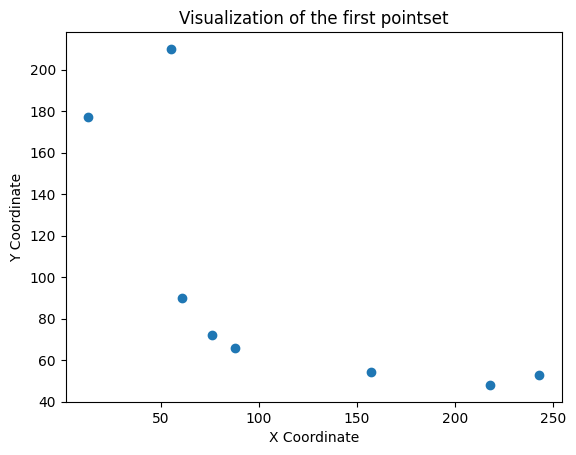

In [ ]:
# Visualize the first pointset
plt.scatter(df['x'][:8], df['y'][:8])
plt.title('Visualization of the first pointset')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

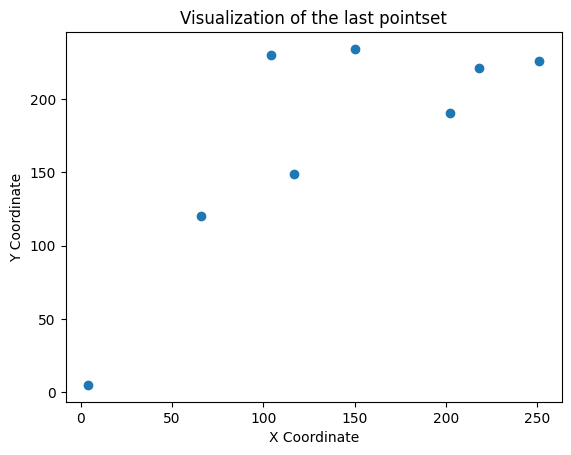

In [ ]:
# Visualize the last pointset
plt.scatter(df['x'][3299:3307], df['y'][3299:3307])
plt.title('Visualization of the last pointset')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()

# **Algorithm**

We first define a couple of helper functions, to help us generate all edges of a complete graph given its vertices, and to transfrom a partition into forests describing the generated edges.

In [ ]:
def generate_edges(vertices):
  edges = []
  for u in range(len(vertices)):
    for v in range(u+1,len(vertices)):
      if u != v: edges.append((vertices[u],vertices[v]))
  return edges

def from_part_to_forests(part):
  forests = []
  for p in range(len(part)):
    forests.append([])
    for e in part[p]:
      forests[p].append(edges[e])
  return forests

def from_part_to_forests_data(part,edges_data):
  forests_data = []
  for p in range(len(part)):
    forests_data.append([])
    for e in (part[p]):
      forests_data[p].append(edges_data[e])
  return forests_data

Next, we define a function which checks whether decompostions are planar for each point set. We thus define the function ```check_forests_planar```.

In [ ]:
def ccw(A,B,C):
  #(C.y-A.y) * (B.x-A.x) > (B.y-A.y) * (C.x-A.x)
  return (int(C[1])-int(A[1])) * (int(B[0])-int(A[0])) > (int(B[1])-int(A[1])) * (int(C[0])-int(A[0]))

# Return true if line segments AB and CD intersect
def intersect(A,B,C,D):
  return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

def check_planar(forest):
  for a in forest:
    for b in forest:
      if a != b and intersect(a[0],a[1],b[0],b[1]): return False
  return True

def check_forests_planar(fore):
  for fo in fore:
    if not check_planar(fo): return False
  return True

In [ ]:
def check_pointset(m,n):
  vertices_data = data[m:m+n]
  edges_data = generate_edges(vertices_data)
  forbidden = []
  for e in range(28):
    edge = edges_data[e]
    for f in range(e,28):
      fedge = edges_data[f]
      if intersect(edge[0],edge[1],fedge[0],fedge[1]): forbidden.append([e,f])
  for check in colorings:
    works = True
    for forest in check:
      for intersection in forbidden:
        if intersection[0] in forest and intersection[1] in forest: works = False
    if works: return(vertices_data,check)
  return None

To help us visualize the results, we define a plotting function.

In [ ]:
def plot_edges(components, vertices_data, save_path=None):

    edges_data = generate_edges(vertices_data)
    edge_styles = ['-', '--', '-.', ':', '*']
    edge_colors = ['b', 'g', 'r', 'm', 'c', 'k']
    vertex_marker = 'ko'

    fig, ax = plt.subplots(figsize=(8, 8))

    for i, component in enumerate(components):
        for j, edge_idx in enumerate(component):
            edge = edges_data[edge_idx]
            x, y = zip(edge[0], edge[1])
            style = edge_styles[i % len(edge_styles)]
            color = edge_colors[i % len(edge_colors)]
            ax.plot(x, y, linestyle=style, linewidth=3, color=color, marker='o')

        for edge_idx in component:
            for vertex in edges_data[edge_idx]:
                ax.plot(vertex[0], vertex[1], vertex_marker)

    ax.set_axis_off()

    if save_path:
        plt.savefig(save_path, format='svg', bbox_inches='tight')
    plt.show()

We now start building our decompositions. We start by generating all stars, which we will use to form all possible broken double star decompositons. We will consider only those consisting of three edges, as those are the only plausible candidates.

In [ ]:
def generate_stars(v,edges):
  stars = []
  for i in range(28):
    if edges[i][0] == v or edges[i][1] == v:
      more = []
      for s in stars:
        if len(s) in {1,2}: more.append(s+[edges[i]])
      stars += more
      stars.append([edges[i]])
  return stars

In [ ]:
vertices = [i for i in range(8)]
edges = generate_edges(vertices)

all_stars = []

for i in range(8):
  all_stars += generate_stars(i,edges)

stars1 = []
stars2 = []
stars3 = []

for s in all_stars:
  if len(s) == 1: stars1.append(s)
  elif len(s) == 2: stars2.append(s)
  else: stars3.append(s)

We define functions which will help us determine whether two stars are disjoint (and can therefore be part of the same forest). We also want to be able to check which vertex is the center of a star.

In [ ]:
def stars_disjoint(s1, s2):
  star1 = set()
  for a in s1:
    star1.add(a[0])
    star1.add(a[1])
  star2 = set()
  for b in s2:
    star2.add(b[0])
    star2.add(b[1])
  return star1.isdisjoint(star2)

def check_center(v,star):
  app = 0
  for a in star:
    if a[0] == v: app +=1
    if a[1] == v: app +=1
  return app == 3

Next, for each edge of the graph, we generate the stars centered at its endpoints.

In [ ]:
parts = {}
for u in vertices:
  for v in vertices[u+1:]:
    parts[(u,v)] = []

for v in vertices:
  for u in vertices[v+1:]:
    for star in stars3:
      for other_star in stars3:
        if check_center(v,star) and check_center(u,other_star) and stars_disjoint(star, other_star):
          parts[(v,u)].append([star,other_star])
        elif check_center(u,star) and check_center(v,other_star) and stars_disjoint(star, other_star):
          parts[(v,u)].append([star,other_star])

for key in parts.keys():
  for i in range(40):
    parts[key][i] = list(map(edges.index,itertools.chain.from_iterable(parts[key][i])))


In [ ]:
len(parts[(0,1)])

40

Now we need to find all matchings in the graph, which we will use as bases for building the broken star forests. There are $26520$ of them.

In [ ]:
matchings = []

for e1 in range(28):
  for e2 in range(1,28):
    for e3 in range(2,28):
      for e4 in range(3,28):
        a1 = edges[e1]
        a2 = edges[e2]
        a3 = edges[e3]
        a4 = edges[e4]
        if stars_disjoint([a1],[a2]) and stars_disjoint([a1],[a3]) and stars_disjoint([a1],[a4]) and stars_disjoint([a2],[a3]) and stars_disjoint([a2],[a4]) and stars_disjoint([a3],[a4]):
          matchings.append([e1,e2,e3,e4])

In [ ]:
size = len(data)
size

26520

The next step is to generate all decompositions which we would like to check. The first example is printed in the output.

Finally, we go through all point sets and all generated broken double star decompositions. The output of this code is saved in file ```8-5-partitions.txt```.

In [ ]:
colorings = []
checkss = 0
for matching in matchings:
  e1,e2,e3,e4 = matching
  s = set(matching)
  for p1 in parts[edges[e1]]:
    checkss += 1
    if checkss%10000 == 1: print("checked p1 {} times".format(checkss))
    s1 = set(p1)
    for p2 in parts[edges[e2]]:
      s2 = set(p2)
      for p3 in parts[edges[e3]]:
        s3 = set(p3)
        if s1.isdisjoint(s2) and s1.isdisjoint(s3) and s2.isdisjoint(s3)\
        and s1.isdisjoint(s) and s2.isdisjoint(s) and s3.isdisjoint(s):
          if len(colorings) == 1: print(colorings)
          colorings.append([matching,p1,p2,p3,list({0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27}.difference(s.union(s1.union(s2.union(s3)))))])


checked p1 1 times
[[[0, 13, 22, 27], [1, 3, 5, 8, 10, 12], [7, 14, 16, 2, 19, 21], [9, 18, 23, 4, 15, 26], [6, 11, 17, 20, 24, 25]]]
checked p1 10001 times
checked p1 20001 times
checked p1 30001 times
checked p1 40001 times
checked p1 50001 times
checked p1 60001 times
checked p1 70001 times


In [ ]:
for i in range(1,3316):
  if i%15 == 1: print("checked {}".format(i))
  check = check_pointset(size-i*8,8)
  if check is not None: print(check)

For illustrations of the decomposed point sets, please take a look at the ```star-forests-8-pics.ipynb``` notebook.

Again, this is method that has proven to be useful for small point sets. When trying to use it for point sets on $10$ vertices, we run into memory troubles. Thus we will again need to reinvent the way we find partitions.